## Import libery

In [94]:
import os
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


## Read raw data

In [105]:
files_path = []
path = "./RawData/new"
for path, subdirs, files in os.walk(path):
    for name in files:
        files_path.append(os.path.join(path, name))
print(files_path)

['./RawData/new/Back_Running_1618761933350.csv', './RawData/new/Front_Standing_1618760823322.csv', './RawData/new/Back_Walking_1618761216758.csv', './RawData/new/Front_Walking_1618761569619.csv', './RawData/new/Front_Running_1618762274220.csv', './RawData/new/Back_Standing_1618760445930.csv']


In [106]:
def visual_data(data_path):
    data = pd.read_csv(data_path, sep=',',  names=["time_ms", "x", "y","z"])
    print(data_path,len(data))

# Plot
    plt.figure(figsize = (15,4), dpi=100)
    plt.subplot(311)
    plt.plot(data['time_ms'],data['x'])
#plt.plot(data['time_ms'][300:320],data['y'][300:320])
#plt.xticks(data['time_ms'][300:320])
    plt.xlabel('time (ms)')
    plt.ylabel('x')

    plt.subplot(312)
    plt.plot(data['time_ms'],data['y'])
#plt.plot(data['time_ms'][300:320],data['y'][300:320])
#plt.xticks(data['time_ms'][300:320])
    plt.xlabel('time (ms)')
    plt.ylabel('y')

    plt.subplot(313)
    plt.plot(data['time_ms'],data['z'])
#plt.plot(data['time_ms'][300:320],data['y'][300:320])
#plt.xticks(data['time_ms'][300:320])
    plt.xlabel('time (ms)')
    plt.ylabel('z')

    plt.show()

./RawData/new/Back_Running_1618761933350.csv 15063


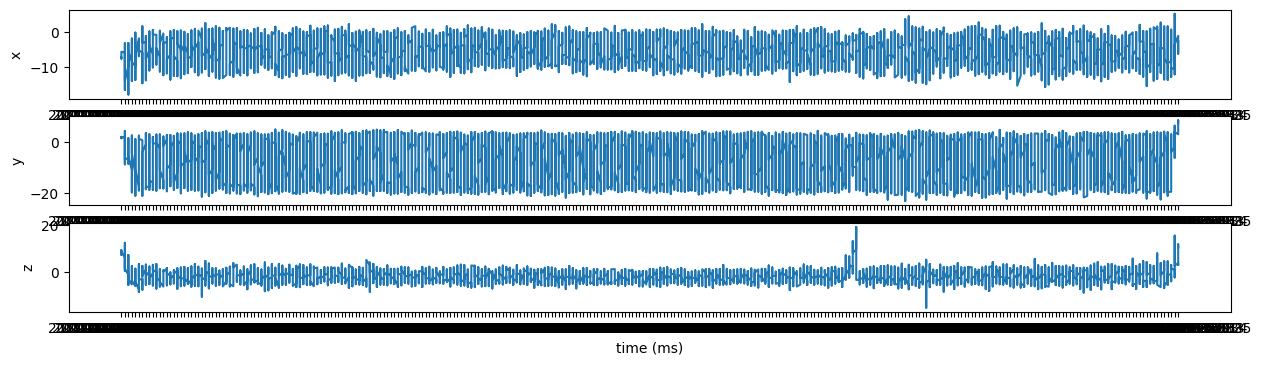

./RawData/new/Front_Standing_1618760823322.csv 15083


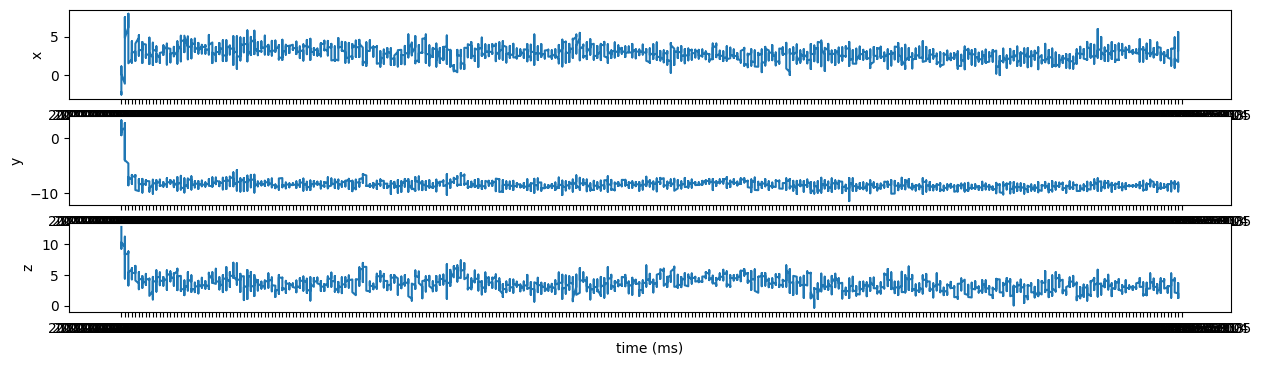

./RawData/new/Back_Walking_1618761216758.csv 15200


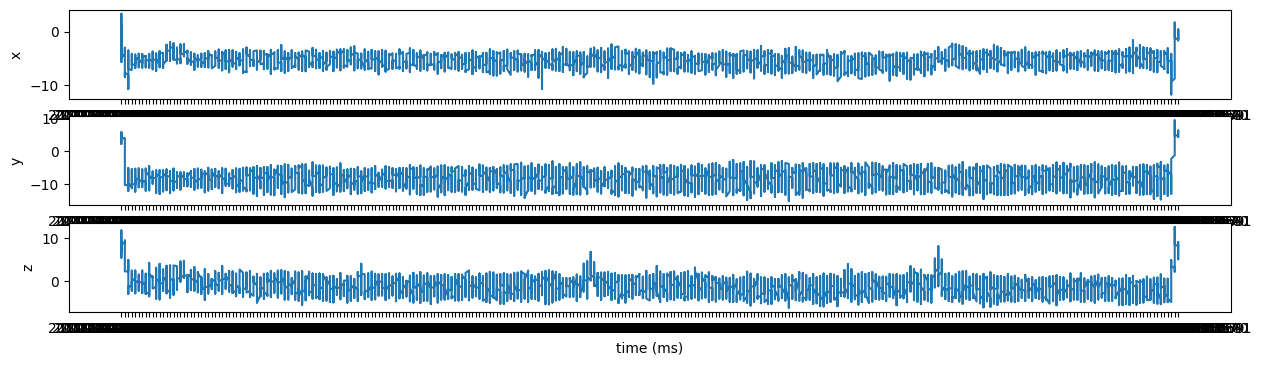

./RawData/new/Front_Walking_1618761569619.csv 15018


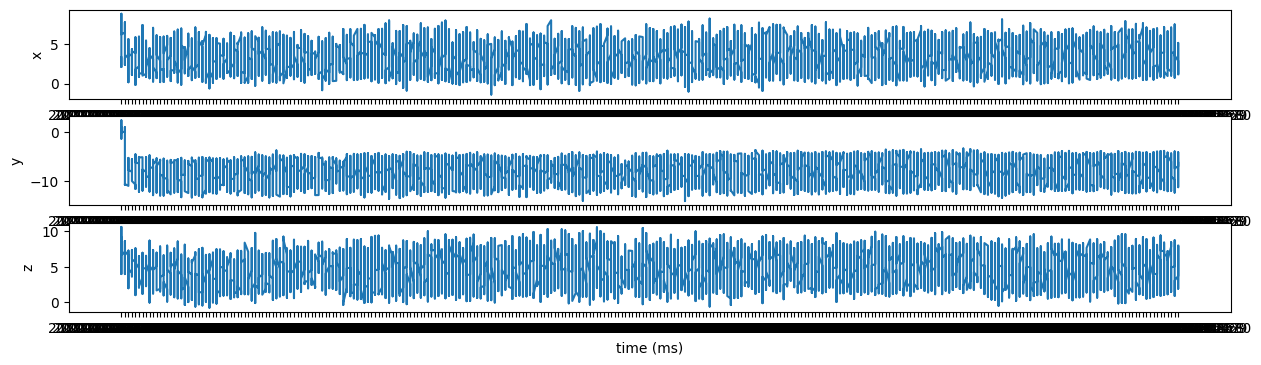

./RawData/new/Front_Running_1618762274220.csv 14985


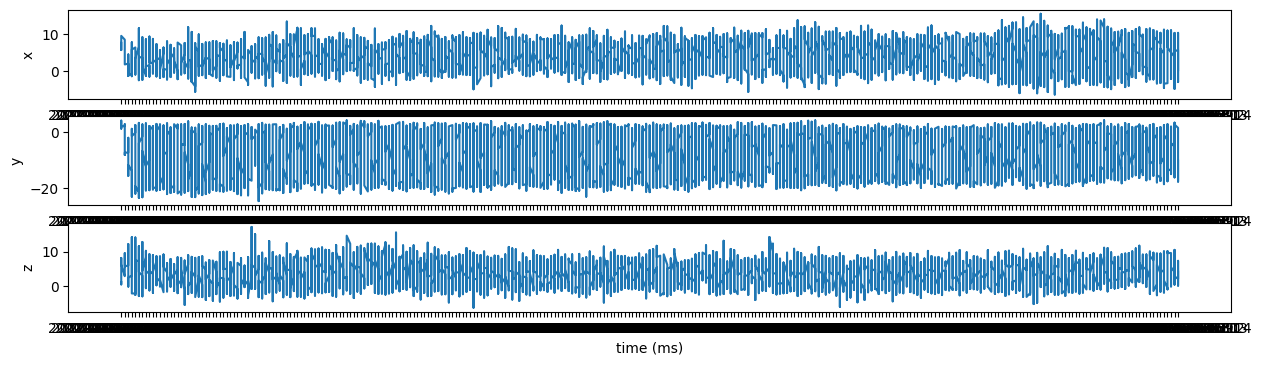

./RawData/new/Back_Standing_1618760445930.csv 15127


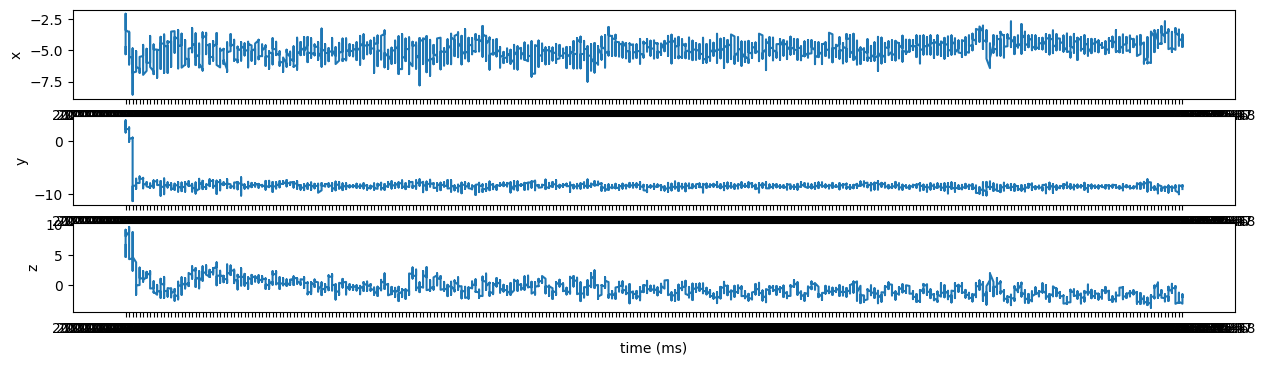

In [107]:
for f in files_path:
    visual_data(f)

## Transform raw data to SD

In [108]:
def data_to_mean_sd(data_path):
  # read data from csv
    data = pd.read_csv(data_path, sep=',',  names=["time_ms", "x", "y","z"], usecols = ["x", "y","z"])

  # get mean and sd every 15 row
    step = 15
    df_mean = data.groupby(data.index // step).mean()
    df_sd = data.groupby(data.index // step).std()

  # rename columns name
    df_mean.rename(columns={'x': 'x_mean', 'y': 'y_mean', 'z':'z_mean'}, inplace=True)
    df_sd.rename(columns={'x': 'x_sd', 'y': 'y_sd', 'z':'z_sd'}, inplace=True)

  # concat mean and sd to a dataframe
    result = pd.concat([df_mean.iloc[3:-3], df_sd.iloc[3:-3]], axis=1)
    result.dropna(inplace=True)

  # add label column
    if 'Running' in data_path:
        result['label'] = 1
        result['activity'] = 'run'
    elif 'Walking' in data_path:
        result['label'] = 2
        result['activity'] = 'walk'
    elif 'Standing' in data_path:
        result['label'] = 3
        result['activity'] = 'stand'

    if 'back' in data_path.lower():
        result['position'] = 'back'
    elif 'front' in data_path.lower():
        result['position'] = 'front'

    if 'New_Version' in data_path:
        result['by'] = 'yui'
    else:
        result['by'] = 'benz'
    return result

In [109]:
data_pd = pd.DataFrame()
for f in files_path:
    data_pd = data_pd.append(data_to_mean_sd(f))

In [110]:
data_pd.shape

(5999, 10)

In [112]:
data_pd.head()

x_mean     y_mean    z_mean      x_sd      y_sd      z_sd  label  \
3 -8.556180  -5.418563 -0.424744  4.663142  2.217493  3.166228      1   
4 -7.191923  -7.644760  0.727381  4.196430  8.194462  3.844719      1   
5 -5.155672  -6.553130 -1.583893  1.741433  6.063756  1.848706      1   
6 -4.715764  -6.280821 -0.056984  2.800738  7.460706  1.560044      1   
7 -6.992400 -11.567061 -0.868803  3.652910  7.621526  2.350456      1   

  activity position    by  
3      run     back  benz  
4      run     back  benz  
5      run     back  benz  
6      run     back  benz  
7      run     back  benz

In [113]:
data_pd[data_pd.isna().any(axis=1)].shape

(0, 10)

In [114]:
data_pd.head()

x_mean     y_mean    z_mean      x_sd      y_sd      z_sd  label  \
3 -8.556180  -5.418563 -0.424744  4.663142  2.217493  3.166228      1   
4 -7.191923  -7.644760  0.727381  4.196430  8.194462  3.844719      1   
5 -5.155672  -6.553130 -1.583893  1.741433  6.063756  1.848706      1   
6 -4.715764  -6.280821 -0.056984  2.800738  7.460706  1.560044      1   
7 -6.992400 -11.567061 -0.868803  3.652910  7.621526  2.350456      1   

  activity position    by  
3      run     back  benz  
4      run     back  benz  
5      run     back  benz  
6      run     back  benz  
7      run     back  benz

In [115]:
data_pd.dropna(inplace=True)

In [116]:
data_pd.shape

(5999, 10)

In [117]:
# data_pd.to_csv('mean_sd_v2.csv',index=False)

## Remove Outlier

In [118]:
from scipy.stats import zscore
import numpy as np

In [119]:
z_scores = zscore(data_pd[['x_sd','y_sd','z_sd']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_df = data_pd[filtered_entries]

In [120]:
index_walk = data_pd['activity']=='walk'
index_run = data_pd['activity']=='run'
index_stand = data_pd['activity']=='stand'
df_walk = data_pd[index_walk]
df_run = data_pd[index_run]
df_stand = data_pd[index_stand]

In [121]:
print('walk:  ',df_walk.shape)
print('run:   ',df_run.shape)
print('stand: ',df_stand.shape)

walk:   (2004, 10)
run:    (1992, 10)
stand:  (2003, 10)


In [122]:
z_scores = zscore(df_walk[['x_sd','y_sd','z_sd']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_walk = df_walk[filtered_entries]
new_walk = new_walk[new_walk['activity']=='walk'].sample(frac=0.35)

In [123]:
z_scores = zscore(df_run[['x_sd','y_sd','z_sd']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_run = df_run[filtered_entries]

In [124]:
z_scores = zscore(df_stand[['x_sd','y_sd','z_sd']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)
new_stand = df_stand[filtered_entries]

In [125]:
print('walk:  ',new_walk.shape)
print('run:   ',new_run.shape)
print('stand: ',new_stand.shape)

walk:   (699, 10)
run:    (1949, 10)
stand:  (1929, 10)


In [126]:
new_stand.head()

x_mean    y_mean    z_mean      x_sd      y_sd      z_sd  label  \
5   3.993012 -6.945472  5.102678  0.543330  0.247172  0.591133      3   
7   2.808325 -7.625765  5.249368  0.758440  0.431261  0.620625      3   
8   3.338258 -7.426562  5.252241  0.585813  0.371707  0.289331      3   
9   2.267857 -7.894563  4.899644  0.402842  0.247493  0.321965      3   
10  3.119102 -7.399746  5.292784  0.279797  0.266988  0.181024      3   

   activity position    by  
5     stand    front  benz  
7     stand    front  benz  
8     stand    front  benz  
9     stand    front  benz  
10    stand    front  benz

In [127]:
new_df = pd.concat([new_walk, new_run,new_stand])

In [128]:
new_df.shape

(4577, 10)

In [131]:
new_df.to_csv('mean_sd_remove_outliner.csv',index=False)